In [1]:
# Import of the data 
# This can take a while 

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Window

DAU_SCHEMA = T.StructType([
    T.StructField('userId', T.StringType()),
    T.StructField('createdAt', T.StringType()),
    T.StructField(
        'data', T.StructType([
            T.StructField('score', T.LongType()),
        ]),
    ),
])

PATH = "s3a://alpha-health-pro/red/evermind/events/2020/*/*/*/*"
evermindDF_raw = spark.read.schema(schema=DAU_SCHEMA).json(PATH)
evermindDF_raw.count()

ModuleNotFoundError: No module named 'pyspark'

In [2]:
# Transform data into a pandas dataframe
df = evermindDF_raw\
    .withColumn("date", F.date_format(F.to_timestamp(F.col("createdAt")), "yyyy-MM-dd"))\
    .toPandas()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df.head()

,userId,createdAt,data,date
0,164d3b3b-a4b3-47bd-9291-80cf1fdab99e,2020-03-20T08:33:41.209147+01:00,"(None,)",2020-03-20
1,164d3b3b-a4b3-47bd-9291-80cf1fdab99e,2020-03-20T08:33:41.211297+01:00,"(None,)",2020-03-20
2,164d3b3b-a4b3-47bd-9291-80cf1fdab99e,2020-03-20T08:33:41.239939+01:00,"(None,)",2020-03-20
3,164d3b3b-a4b3-47bd-9291-80cf1fdab99e,2020-03-20T08:33:41.572488+01:00,"(None,)",2020-03-20
4,164d3b3b-a4b3-47bd-9291-80cf1fdab99e,2020-03-20T08:33:41.573622+01:00,"(None,)",2020-03-20


In [4]:
import re
import numpy as np 

def getKey(k, raw):
    """
    Function used to return the content for different keys in the data array. 
    This function will be used to create new columns for scores etc.
    """
    if isinstance(raw, float):
        return(float('NaN'))
    
    raw = str(raw)
    #.replace('None', np.NaN)
    
    if k == 'score':
        num = re.search('{}=(\d+)'.format(k), raw)
        if num:
            num = int(num.group(1))
            if num:
                return(num)

    if k == 'answers': 
        ary = re.search(r"\[(.*)\]".format(k), raw)
        print(ary)
        if ary:
            ary = ary.group()
            ary = re.sub('\D', ' ', ary)
            ary = ary.split()
            return(ary)
    
    # if string
    sub_string = re.search('{}=(.+?),'.format(k), raw)
    if sub_string:
        string = sub_string.group(1)
        string = string.replace("'", "")
        return(string)

df['score'] = df['data'].apply(lambda x: getKey('score', x))

In [6]:
import pandas as pd
#Creation of a new dataframe with the times and scores per user
df['date'] = pd.to_datetime(df['date'])
df.dropna(subset = ['score'], inplace=True)
df.sort_values(['userId', 'date'])
valid_ids = df['userId'].unique()
timeScore = df[(df['userId'].isin(valid_ids))]
timeScore = timeScore.groupby('userId')
timeScore = timeScore['date', 'score'].agg(list)

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [7]:
#Get the difference in scores between assessments
def get_scoreDiff(scores):
    differences = []
    if len(scores) == 2:
        diff = int(scores[0]) - int(scores[1])
        return diff
    else:
        return np.nan
timeScore['scoreDiff'] = timeScore['score'].apply(lambda x: get_scoreDiff(x))

In [8]:
#Get the time difference between assessments
def get_timeDiff(time):
    differences = []
    if len(time) == 2:
        diff = time[0] - time[1]
        return diff
    else:
        return np.nan

timeScore['timeDiff'] = timeScore['date'].apply(lambda x: get_timeDiff(x))

In [9]:
timeScore.dropna(subset = ['scoreDiff'], inplace=True)

In [10]:
#Exclude all the users that did the assessment more than once in one day
from datetime import timedelta
timeScore = timeScore[timeScore.timeDiff > timedelta(1)]

In [11]:
#Get categories for the time difference
def get_repeated(diff):

    if diff > timedelta(1) and diff < timedelta(4):
        return 'few days'
    elif diff >= timedelta(4) and diff < timedelta(8):
        return 'week'
    elif diff >= timedelta(8) and diff < timedelta(12):
        return 'more than a week'
    elif diff >= timedelta(12) and diff < timedelta(15):
        return 'two weeks'
    elif diff >= timedelta(15):
        return 'more'

timeScore['repeated'] = timeScore['timeDiff'].apply(lambda x: get_repeated(x))    

In [12]:
timeScore.groupby("repeated").count()

,date,score,scoreDiff,timeDiff
repeated,,,,
few days,1,1,1,1
more,16,16,16,16
more than a week,8,8,8,8
two weeks,2,2,2,2
week,2,2,2,2


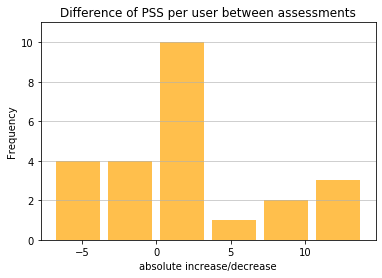

In [38]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=timeScore['scoreDiff'], bins='auto', color='orange',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('absolute increase/decrease')
plt.ylabel('Frequency')
plt.title('Difference of PSS per user between assessments')
maxfreq = n.max()

plt.ylim(0, 11)
plt.savefig('differencePSS.png', dpi = 180, bbox_inches="tight")